<a href="https://colab.research.google.com/github/shahmedh/DEPI-group6/blob/main/EDA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Exploration:**

**Perform exploratory data analysis (EDA) to understand the composition of the images, including the number of bands and their relevance to land type classification**.

**Inspect the dataset for potential issues, such as imbalanced classes, missing data, or mislabeled images.**

**Visualize sample images from different land types (e.g., agricultural land, urban, water, desert) and examine their spectral signatures.**



**Installing and  Importing necessary packages**


In [ ]:
!pip install sentinelhub numpy geopandas shapely rasterio
import requests
from tqdm import tqdm
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os


**Open a connection with the DATASPACE.COPERNICUS SERVER using Token URL, Username and Password**



In [ ]:
import requests

# Copernicus OAuth2 Token URL
TOKEN_URL = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

# Replace with your Copernicus account credentials
EMAIL = "shaimaa.ahmed.business@gmail.com"
PASSWORD = "DEPI2yth!!2025"

# Request payload
payload = {
    "client_id": "cdse-public",
    "username": EMAIL,
    "password": PASSWORD,
    "grant_type": "password"
}

# Request token
response = requests.post(TOKEN_URL, data=payload)

# Extract token if request is successful
if response.status_code == 200:
    ACCESS_TOKEN = response.json().get("access_token")
    print("Access Token retrieved successfully!")
else:
    print(f"Error: {response.status_code}, {response.text}")

Access Token retrieved successfully!


# **Downloading zipped data **



In [ ]:
##import requests
##from tqdm import tqdm

# Product download URL (Replace with your actual product URL)
PRODUCT_URL = "https://download.dataspace.copernicus.eu/odata/v1/Products(2fd9e578-5865-40e8-b3e9-0487d53011c3)/$value"

# Output file name
output_file = "Sentinel2_Image.zip"

# Set Authorization header
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}"
}

# Download the file
with requests.get(PRODUCT_URL, headers=headers, stream=True) as r:
    r.raise_for_status()  # Check for request errors
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024  # 1 KB chunks
    t = tqdm(total=total_size, unit="B", unit_scale=True)

    with open(output_file, "wb") as f:
        for chunk in r.iter_content(chunk_size=block_size):
            f.write(chunk)
            t.update(len(chunk))

print(f"\nDownload completed: {output_file}")

100%|█████████▉| 1.25G/1.25G [03:00<00:00, 2.33MB/s]


Download completed: Sentinel2_Image.zip


# **Testing True color RGB without enhancement**

 RGB Image saved: Sentinel2_TrueColor.png


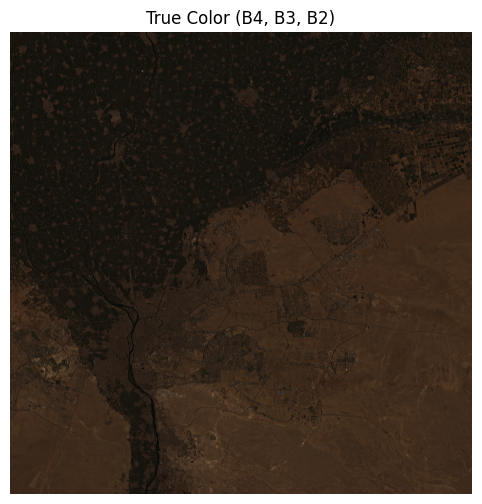

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# Step 1: Extract the Sentinel-2 zip file
zip_file = "Sentinel2_Image.zip"
extract_folder = "Sentinel2_Data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Locate Sentinel-2 Bands (Red, Green, Blue)
band_files = {
    "B4": None,  # Red
    "B3": None,  # Green
    "B2": None   # Blue
}

for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if "B04" in file and file.endswith(".jp2"):
            band_files["B4"] = os.path.join(root, file)
        elif "B03" in file and file.endswith(".jp2"):
            band_files["B3"] = os.path.join(root, file)
        elif "B02" in file and file.endswith(".jp2"):
            band_files["B2"] = os.path.join(root, file)

# Ensure all band files exist
if None in band_files.values():
    raise FileNotFoundError("One or more Sentinel-2 band files (B4, B3, B2) are missing!")

# Step 3: Read Sentinel-2 Bands
def read_band(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1).astype(np.float32)

# Read RGB bands
red = read_band(band_files["B4"])
green = read_band(band_files["B3"])
blue = read_band(band_files["B2"])

# Normalize bands for visualization
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

red_norm = normalize_band(red)
green_norm = normalize_band(green)
blue_norm = normalize_band(blue)

# Step 4: Create True Color Image (B4, B3, B2)
rgb_image = np.dstack((red_norm, green_norm, blue_norm))

# Save True Color Image
rgb_output_path = "Sentinel2_TrueColor.png"
plt.imsave(rgb_output_path, rgb_image)
print(f" RGB Image saved: {rgb_output_path}")

# Step 5: Visualize RGB Image
plt.figure(figsize=(8, 6))
plt.imshow(rgb_image)
plt.title("True Color (B4, B3, B2)")
plt.axis("off")
plt.show()

# Step 6: Display Histograms of Band Reflectance
plt.figure(figsize=(12, 6))
sns.histplot(red.ravel(), bins=100, color="red", label="Red (B4)", kde=True)
sns.histplot(green.ravel(), bins=100, color="green", label="Green (B3)", kde=True)
sns.histplot(blue.ravel(), bins=100, color="blue", label="Blue (B2)", kde=True)

# Add Labels and Legends
plt.xlabel("Reflectance Value")
plt.ylabel("Frequency")
plt.legend()
plt.title("Band Reflectance Histograms (B4, B3, B2)")
plt.show()


**#  Exploratory Data Analysis**
**EDA**


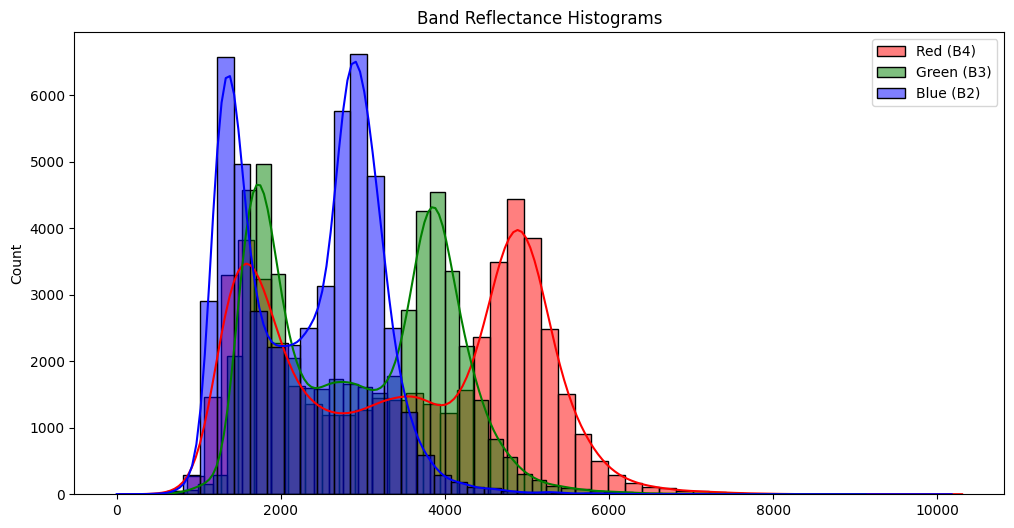

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import gc

# Clean RAM before execution
gc.collect()

# Step 1: Extract the Sentinel-2 zip file
zip_file = "Sentinel2_Image.zip"
extract_folder = "Sentinel2_Data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Locate Sentinel-2 Bands
band_files = {}
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if "B04" in file and file.endswith(".jp2"):
            band_files["B4"] = os.path.join(root, file)
        elif "B03" in file and file.endswith(".jp2"):
            band_files["B3"] = os.path.join(root, file)
        elif "B02" in file and file.endswith(".jp2"):
            band_files["B2"] = os.path.join(root, file)

# Step 3: Read Sentinel-2 Bands

def read_band(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1).astype(np.float32)

# Read selected bands
red = read_band(band_files["B4"])
green = read_band(band_files["B3"])
blue = read_band(band_files["B2"])

# Step 4: EDA - Display Histograms of Band Reflectance
plt.figure(figsize=(12, 6))
sample_size = 50000  # Reduce computations by sampling data
sns.histplot(np.random.choice(red.ravel(), size=sample_size, replace=False), bins=50, color="red", label="Red (B4)", kde=True)
sns.histplot(np.random.choice(green.ravel(), size=sample_size, replace=False), bins=50, color="green", label="Green (B3)", kde=True)
sns.histplot(np.random.choice(blue.ravel(), size=sample_size, replace=False), bins=50, color="blue", label="Blue (B2)", kde=True)
plt.legend()
plt.title("Band Reflectance Histograms")
plt.show()

# Clean up memory
##del red, green, blue, band_files
##gc.collect()


# **Enhanced True Color RGB , where R = B4, G = B3 and B = B2**


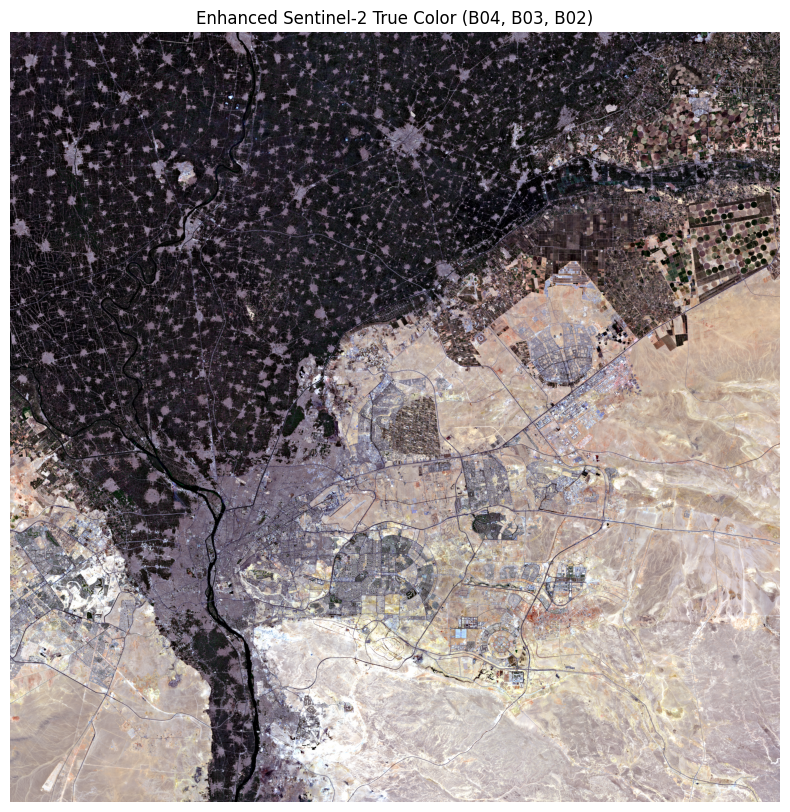

<Figure size 640x480 with 0 Axes>

✅ Image saved: /content/Sentinel2_TrueColor.png


In [ ]:
##import rasterio
##import numpy as np
##import matplotlib.pyplot as plt
##import zipfile
##import os

# Step 1: Extract the downloaded Sentinel-2 zip file
zip_file = "Sentinel2_Image.zip"
extract_folder = "Sentinel2_Data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Locate the bands (Modify this if the folder structure differs)
band_files = {
    "B4": None,  # Red
    "B3": None,  # Green
    "B2": None   # Blue
}

for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if "B04" in file and file.endswith(".jp2"):
            band_files["B4"] = os.path.join(root, file)
        elif "B03" in file and file.endswith(".jp2"):
            band_files["B3"] = os.path.join(root, file)
        elif "B02" in file and file.endswith(".jp2"):
            band_files["B2"] = os.path.join(root, file)

# Step 3: Read the bands
def read_band(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1).astype(np.float32)  # Convert to float for processing

# Step 4: Normalize and enhance contrast
def contrast_stretch(array):
    """ Perform contrast stretching using 2nd and 98th percentiles. """
    p2, p98 = np.percentile(array, (2, 98))
    array = np.clip(array, p2, p98)  # Clip values outside percentile range
    return (array - p2) / (p98 - p2)  # Normalize to 0-1 range

# Read and enhance Red, Green, and Blue bands
red = contrast_stretch(read_band(band_files["B4"]))
green = contrast_stretch(read_band(band_files["B3"]))
blue = contrast_stretch(read_band(band_files["B2"]))

# Return true-color RGB composite
def get_rgb():
    return np.dstack((red, green, blue))  # [B04, B03, B02]

# Display the enhanced image
rgb_image = get_rgb()

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Enhanced Sentinel-2 True Color (B04, B03, B02)")
plt.show()

# Save image to file
output_path = "/content/Sentinel2_TrueColor.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Image saved: {output_path}")


# **EDA for Sentinel-2 Multispectral Images **
```



## **Perform data inspection**

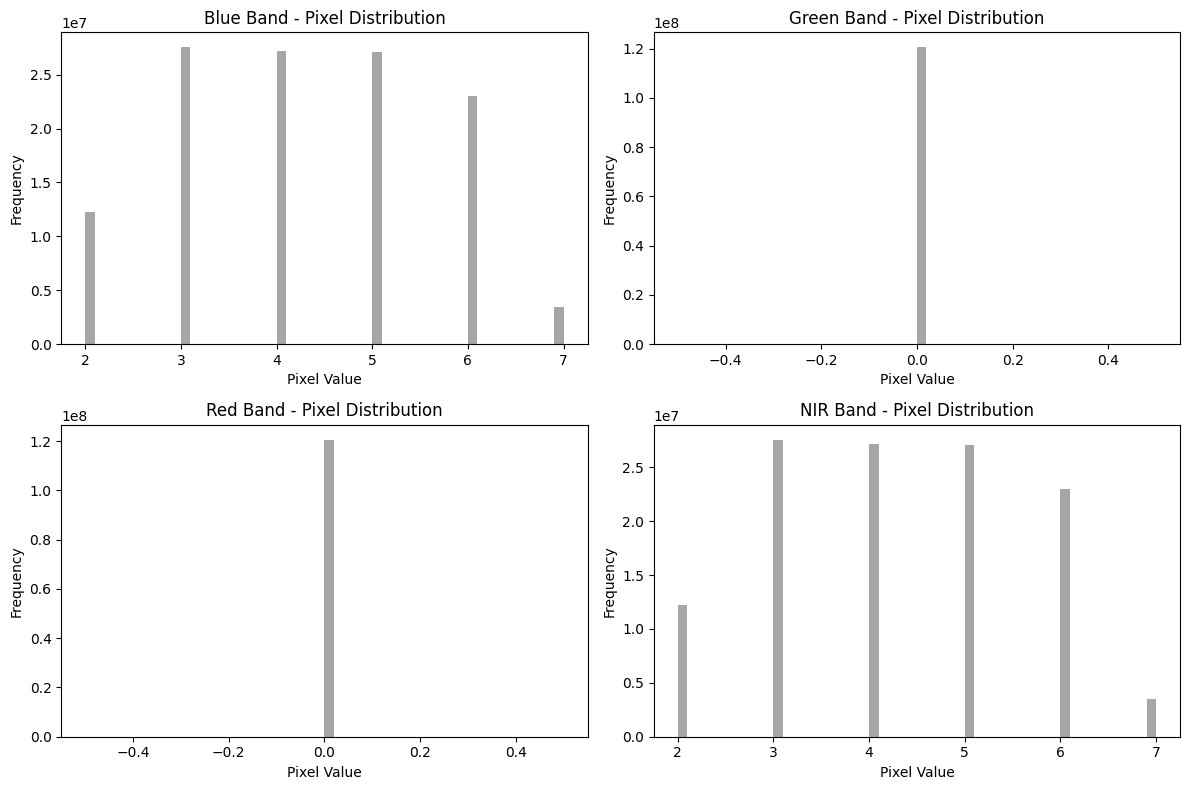

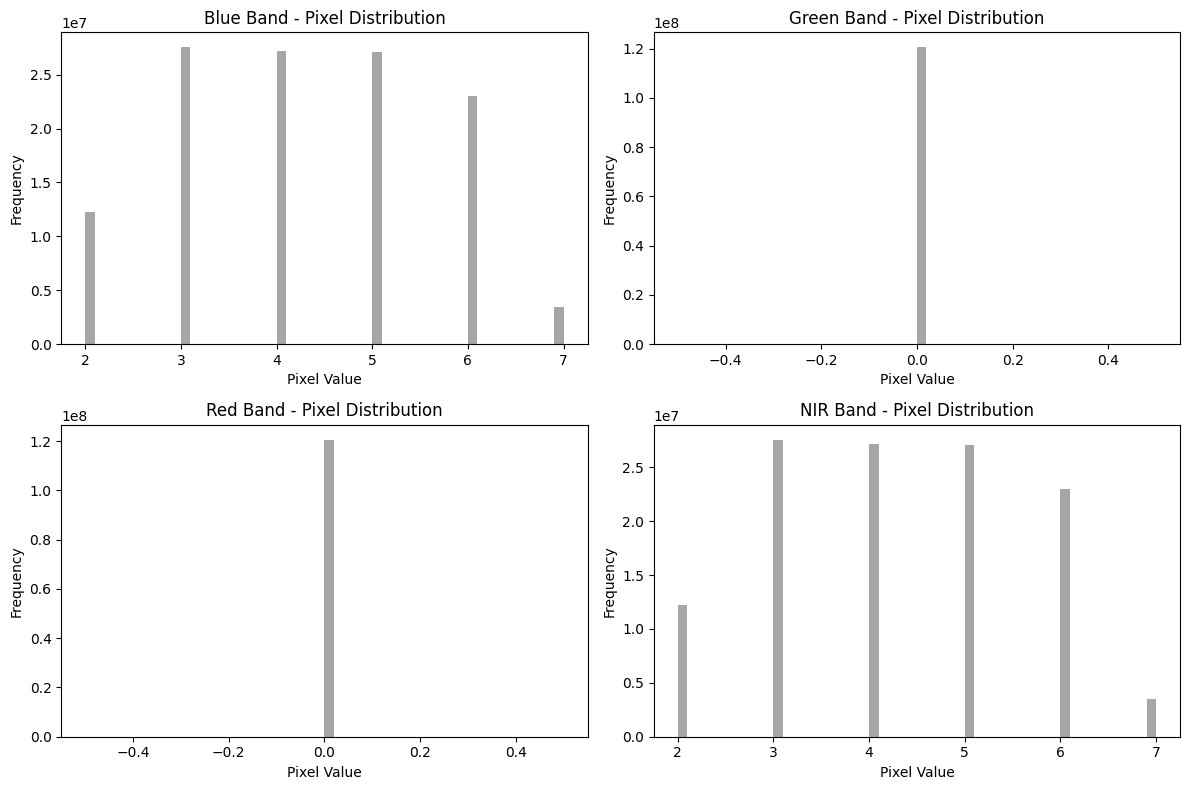


 Band Statistics:
        Min  Max      Mean   Std Dev  NoData Pixels  Outliers
Blue     2    7  4.261427  1.347530              0         0
Green    0    0  0.000000  0.000000              0         0
Red      0    0  0.000000  0.000000              0         0
NIR      2    7  4.261562  1.347366              0         0


In [ ]:
# Perform data inspection
plt.figure(figsize=(12, 8))

for i, (band, file_path) in enumerate(band_paths.items()):
    with rasterio.open(file_path) as src:
        image = src.read(1)  # Read band data

        # Check for NoData values
        nodata_value = src.nodata
        nodata_count = np.sum(image == nodata_value) if nodata_value else 0

        # Compute statistics
        min_val, max_val = np.min(image), np.max(image)
        mean_val, std_val = np.mean(image), np.std(image)
        outliers = np.sum((image < (mean_val - 3 * std_val)) | (image > (mean_val + 3 * std_val)))

        band_stats[band] = {
            "Min": min_val,
            "Max": max_val,
            "Mean": mean_val,
            "Std Dev": std_val,
            "NoData Pixels": nodata_count,
            "Outliers": outliers
        }

        # Plot histogram
        plt.subplot(2, 2, i + 1)
        plt.hist(image.ravel(), bins=50, color="gray", alpha=0.7)
        plt.title(f"{band} Band - Pixel Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Convert stats to DataFrame
df_stats = pd.DataFrame.from_dict(band_stats, orient="index")
# Perform data inspection
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 8))

band_stats = {} # Initialize an empty dictionary to store band statistics

for i, (band, file_path) in enumerate(band_paths.items()):
    with rasterio.open(file_path) as src:
        image = src.read(1)  # Read band data

        # Check for NoData values
        nodata_value = src.nodata
        nodata_count = np.sum(image == nodata_value) if nodata_value is not None else 0

        # Compute statistics
        min_val, max_val = np.min(image), np.max(image)
        mean_val, std_val = np.mean(image), np.std(image)
        outliers = np.sum((image < (mean_val - 3 * std_val)) | (image > (mean_val + 3 * std_val)))

        band_stats[band] = {
            "Min": min_val,
            "Max": max_val,
            "Mean": mean_val,
            "Std Dev": std_val,
            "NoData Pixels": nodata_count,
            "Outliers": outliers
        }

        # Plot histogram
        plt.subplot(2, 2, i + 1)
        plt.hist(image.ravel(), bins=50, color="gray", alpha=0.7)
        plt.title(f"{band} Band - Pixel Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Convert stats to DataFrame
df_stats = pd.DataFrame.from_dict(band_stats, orient="index")
print("\n Band Statistics:\n", df_stats)

# 🔹 What This Code Checks

In [ ]:
from google.colab import files
files.download("/content/Sentinel2_TrueColor.png")
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/My Drive/Sentinel2_TrueColor.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")


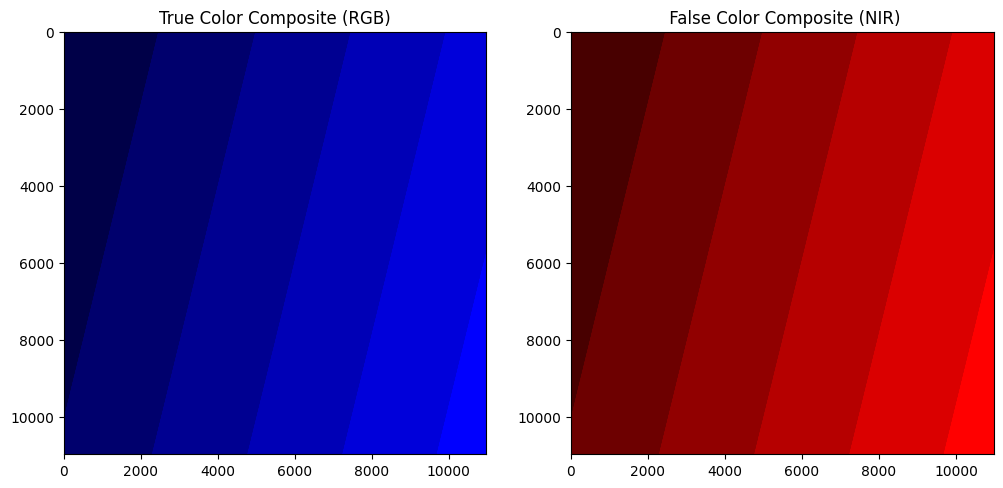

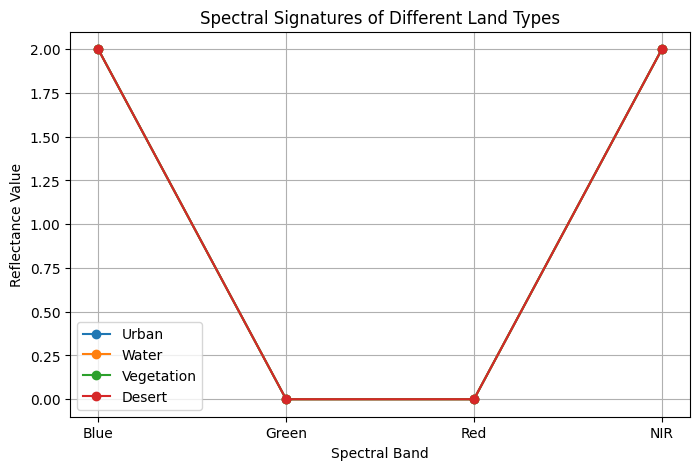

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Define file paths
extract_path = "/content/sentinel2_data"

# Sentinel-2 band file patterns
band_files = {
    "Blue": "B02.jp2",   # Band 2 - Blue
    "Green": "B03.jp2",  # Band 3 - Green
    "Red": "B04.jp2",    # Band 4 - Red
    "NIR": "B08.jp2"     # Band 8 - Near Infrared
}

# Locate each band
band_paths = {}
for band, filename in band_files.items():
    found_files = glob.glob(os.path.join(extract_path, f"**/*{filename}"), recursive=True)
    if found_files:
        band_paths[band] = found_files[0]

# Read band data
band_data = {}
for band, file_path in band_paths.items():
    with rasterio.open(file_path) as src:
        band_data[band] = src.read(1)  # Read band data

# Define sample coordinates (row, col) for different land types
sample_points = {
    "Urban": (600, 800),
    "Water": (1200, 1500),
    "Vegetation": (900, 1000),
    "Desert": (500, 500)
}

# Extract spectral values at sample points
spectral_signatures = {}
for land_type, (row, col) in sample_points.items():
    spectral_signatures[land_type] = [
        band_data["Blue"][row, col],
        band_data["Green"][row, col],
        band_data["Red"][row, col],
        band_data["NIR"][row, col]
    ]

# Convert spectral data to numpy array
spectral_array = np.array(list(spectral_signatures.values()))

# Plot True Color (RGB) and False Color (NIR) Composites
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# True Color (RGB) Composite
rgb_image = np.dstack((band_data["Red"], band_data["Green"], band_data["Blue"]))
axs[0].imshow(rgb_image / np.max(rgb_image))  # Normalize
axs[0].set_title("True Color Composite (RGB)")

# False Color (NIR) Composite
false_color = np.dstack((band_data["NIR"], band_data["Red"], band_data["Green"]))
axs[1].imshow(false_color / np.max(false_color))  # Normalize
axs[1].set_title(" False Color Composite (NIR)")

plt.show()

# Plot Spectral Signatures
plt.figure(figsize=(8, 5))
wavelengths = ["Blue", "Green", "Red", "NIR"]
for land_type, spectrum in spectral_signatures.items():
    plt.plot(wavelengths, spectrum, marker="o", label=land_type)

plt.title("Spectral Signatures of Different Land Types")
plt.xlabel("Spectral Band")
plt.ylabel("Reflectance Value")
plt.legend()
plt.grid(True)
plt.show()
